<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-9123_DL/blob/main/Lab/week2_pytorch_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Made by Sarah

In [ ]:
import torch
import torchvision

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# render the computation graphs
!pip install torchviz
from torchviz import make_dot

     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=31ea723ef1ddf3227d9051d4d556f6d445dae146e218f685aebc24453fa3eecf
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


# Autograd

Automatic differentiation is one of important developments that allowed machine learning to become computationally feasible and thus widespread. This is one of the clearest and most helpful explanations of automatic differentiation I've encountered: http://colah.github.io/posts/2015-08-Backprop/. For the mathematically curious, this is an excellent detailed discussion of automatic differentiation: https://www.jmlr.org/papers/volume18/17-468/17-468.pdf.

Some things to note about autograd for our purposes here:
- variables keep track of what operation produced them and a computation graph of these operations is recorded (variables generated by operations are generally ones which are transformations of earlier inputs and w/r/t which they have partial derivatives which you want to use later)
- reverse-mode differentiation computes the value of $\frac{\partial \text{ output}}{\partial \text{node}}$ for each node in the graph
- this partial derivative corresponds to the influence of a given node on the output in question
- when we call ```backward()```, we are causing all of the contributing partial derivatives to be computed
- the influence of a given node on the output depends only on its influence on its child nodes, which have already been computed (n.b. if this sounds a lot like dynamic programming, that's because it is - see blog post linked above)

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

$$Q = 3a^{3} - b^{2}$$

In [ ]:
Q = 3*a**3 - b**2

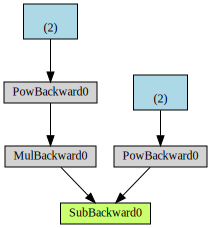

In [ ]:
make_dot(Q)

In [ ]:
external_grad = torch.tensor([1., 1.]) # a tensor for partial derivative of Q wrt itself
Q.backward(gradient=external_grad)

We expect the partial derivatives to be:

$$\frac{\partial Q}{\partial a} = 9a^{2}$$

$$\frac{\partial Q}{\partial b} = -2b$$

In [ ]:
# check this is true
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


# Using a dataset

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True, pin_memory=True)
images, labels = iter(trainDataLoader).next()

# Linear Model

In [ ]:
class LinearReg(torch.nn.Module):
    def __init__(self):
        super(LinearReg, self).__init__()
        self.linear = torch.nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        transformed_x = self.linear(x) # n.b.: object-oriented API layers are 
        # themselves modules, so when the outer "network" module is called, 
        # this calls the self.forward() methods of its internal modules (layers)
        # recursively
        return transformed_x

In [ ]:
net = LinearReg().cuda()

Loss = torch.nn.CrossEntropyLoss()
# n.b. the logsoftmax + NLL (negative log likelihood) loss ops are combined in the CrossEntropyLoss 
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
# the weights and biases in net's linear layer are gpu tensors
print(net.linear.weight.device)
print(net.linear.bias.device)

cuda:0
cuda:0


In [ ]:
# what device is images on
images.device

device(type='cpu')

In [ ]:
# labels
labels.device

device(type='cpu')

In [ ]:
# move labels to the gpu
labels = labels.cuda()
labels.device

device(type='cuda', index=0)

In [ ]:
# what happens when the input to the network is *not* on the gpu:
out = net(images)

# same result as using the call method net(images)
#out = net.forward(images)

#out = net.linear(images.view(-1, 28*28)) # also same

#out = net.linear.forward(images.view(-1, 28*28)) # also same

RuntimeError: ignored

In [ ]:
images = images.cuda()
images.device

device(type='cuda', index=0)

In [ ]:
out = net(images)

In [ ]:
out.device

device(type='cuda', index=0)

In [ ]:
out.grad_fn

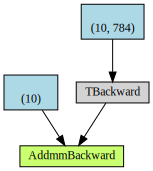

In [ ]:
make_dot(out)

In [ ]:
# Loss applies logsoftmax to ''out'', then applies negative log likelihood loss
# between ''out'' and ''labels''
fit = Loss(out, labels)

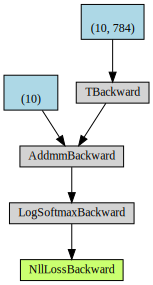

In [ ]:
make_dot(fit)

In [ ]:
print(fit.grad_fn.next_functions)
print(fit.grad_fn.next_functions[0][0].next_functions)
print(fit.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(fit.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[2][0].next_functions)

((<LogSoftmaxBackward object at 0x7f8c6c646cf8>, 0),)
((<AddmmBackward object at 0x7f8c6eea5400>, 0),)
((<AccumulateGrad object at 0x7f8c6efd1c50>, 0), (None, 0), (<TBackward object at 0x7f8c6c646f28>, 0))
((<AccumulateGrad object at 0x7f8c6c6462b0>, 0),)


In [ ]:
print(fit.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].variable)
# is a thing whose gradients get accumulated - the bias tensor
fit_grad_variable_bias = fit.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].variable

Parameter containing:
tensor([ 0.0328, -0.0267,  0.0333,  0.0287,  0.0002,  0.0060, -0.0245, -0.0038,
         0.0055,  0.0119], device='cuda:0', requires_grad=True)


In [ ]:
print(fit.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[2][0].next_functions[0][0].variable)
# is a thing whose gradients get accumulated - the weight tensor
fit_grad_variable_weight = fit.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[2][0].next_functions[0][0].variable

Parameter containing:
tensor([[-0.0122, -0.0355, -0.0309,  ..., -0.0274,  0.0118, -0.0219],
        [ 0.0157,  0.0169,  0.0100,  ...,  0.0069, -0.0351,  0.0356],
        [-0.0022,  0.0357,  0.0121,  ...,  0.0272,  0.0342,  0.0190],
        ...,
        [-0.0346,  0.0017,  0.0089,  ...,  0.0138,  0.0015, -0.0006],
        [-0.0238,  0.0168,  0.0102,  ...,  0.0070,  0.0349, -0.0169],
        [-0.0156, -0.0012, -0.0211,  ...,  0.0353,  0.0154,  0.0327]],
       device='cuda:0', requires_grad=True)


In [ ]:
print(net.linear.bias == fit_grad_variable_bias)
print(net.linear.weight == fit_grad_variable_weight)

tensor([True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')


In [ ]:
print(net.linear.weight.grad)
print(net.linear.bias.grad)

None
None


In [ ]:
fit.backward()

In [ ]:
# weights and biases now updated with gradients wrt fit
print(net.linear.weight.grad)
print(net.linear.bias.grad)

tensor([[ 0.0000e+00,  1.3557e-05,  1.3557e-05,  ...,  1.3514e-03,
          1.3557e-05,  0.0000e+00],
        [ 0.0000e+00,  1.0328e-05,  1.0328e-05,  ...,  1.3653e-03,
          1.0328e-05,  0.0000e+00],
        [ 0.0000e+00,  1.5866e-05,  1.5866e-05,  ..., -1.3946e-03,
          1.5866e-05,  0.0000e+00],
        ...,
        [ 0.0000e+00,  1.3639e-05,  1.3639e-05,  ...,  1.5273e-03,
          1.3639e-05,  0.0000e+00],
        [ 0.0000e+00,  9.3135e-06,  9.3135e-06,  ...,  1.4215e-03,
          9.3135e-06,  0.0000e+00],
        [ 0.0000e+00, -1.1401e-04, -1.1401e-04,  ...,  9.1818e-04,
         -1.1401e-04,  0.0000e+00]], device='cuda:0')
tensor([ 0.0340,  0.0188,  0.0466,  0.0614, -0.1547,  0.0319, -0.0603,  0.0229,
         0.0220, -0.0226], device='cuda:0')


Tip: when using the gpu, it's a good idea to use ''Factory reset runtime'' every so often to make sure all data and errors are completely cleared so as to prevent unexpected problems.